In [61]:
import numpy as np
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl
from sklearn.metrics import r2_score, mean_squared_error

divs_in = 3
names_in = [chr(i) for i in range(ord("a"), ord("a") + divs_in)]
divs_out = 7
names_out = [chr(i) for i in range(ord("a"), ord("a") + divs_out)]

friction_univ = np.linspace(0.1, 0.3, divs_in)
friction = ctrl.Antecedent(friction_univ, 'friction')
friction.automf(names=names_in)

initial_v_univ = np.linspace(1, 5, divs_in)
initial_v = ctrl.Antecedent(initial_v_univ, 'initial_v')
initial_v.automf(names=names_in)

final_x_univ = np.linspace(0.1, 12.8, divs_out)
final_x = ctrl.Consequent(final_x_univ, 'final_x')
final_x.automf(names=names_out)

In [62]:
rules = []

for f, f_n in zip(friction_univ, names_in):
    for v, v_n in zip(initial_v_univ, names_in):
        x_true = v * v / (2 * f * 9.81)
        x_pred_idx = np.abs(final_x_univ - x_true).argmin()
        x_pred_n = names_out[x_pred_idx]
        rules.append(ctrl.Rule(friction[f_n] & initial_v[v_n], final_x[x_pred_n]))

In [63]:
final_x_ctrl = ctrl.ControlSystem(rules)
final_x_sim = ctrl.ControlSystemSimulation(final_x_ctrl)

In [69]:
size = 30
fs, vs = np.meshgrid(np.linspace(0.1, 0.3, size), np.linspace(1, 5, size))
x_trues = np.zeros_like(fs)
x_preds = np.zeros_like(fs)

for f_idx in range(size):
    for v_idx in range(size):
        f = fs[f_idx, v_idx]
        v = vs[f_idx, v_idx]

        x_trues[f_idx, v_idx] = v * v / (2 * f * 9.81)

        final_x_sim.input["friction"] = f
        final_x_sim.input["initial_v"] = v
        final_x_sim.compute()
        x_preds[f_idx, v_idx] = final_x_sim.output["final_x"]

print("R2", r2_score(x_trues, x_preds))
print("MSE", mean_squared_error(x_trues, x_preds))

R2 0.7393153060100425
MSE 0.8850051309810973


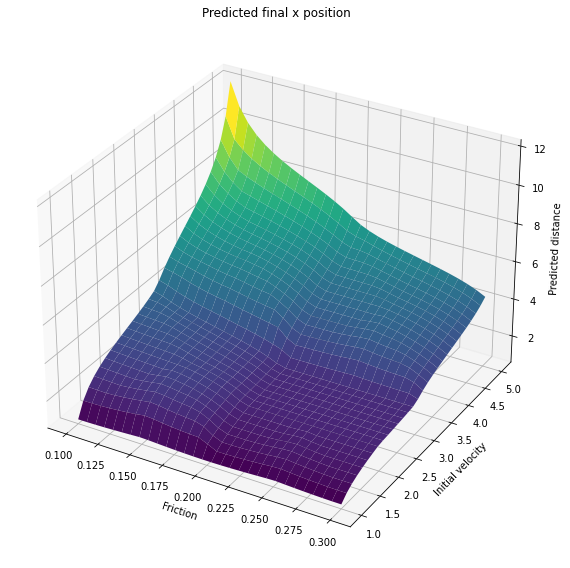

In [72]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(fs, vs, x_preds, rstride=1, cstride=1, cmap='viridis',
                linewidth=0.4, antialiased=True)

ax.set_title("Predicted final x position")
ax.set_xlabel("Friction")
ax.set_ylabel("Initial velocity")
ax.set_zlabel("Predicted distance")

ax.view_init(30, 300)
fig.tight_layout()
fig.savefig("pred.png", dpi=100)

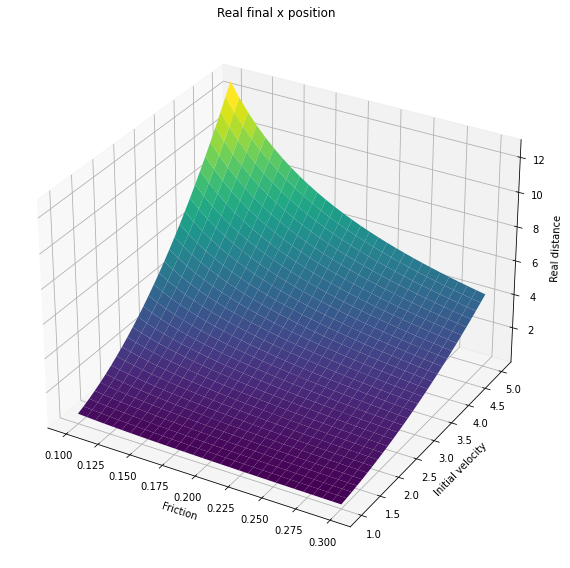

In [73]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(fs, vs, x_trues, rstride=1, cstride=1, cmap='viridis',
                linewidth=0.4, antialiased=True)

ax.set_title("Real final x position")
ax.set_xlabel("Friction")
ax.set_ylabel("Initial velocity")
ax.set_zlabel("Real distance")

ax.view_init(30, 300)
fig.tight_layout()
fig.savefig("true.png", dpi=100)